<center>

# <font size="6" color="darkblue">Trabalho Laboratorial 2</font>

<br><br>

## <font size="4" color="black">Instituto Superior de Engenharia de Lisboa</font>

### Aprendizagem Automática

#### Docente: G. Marques

<br>

#### Realizado por:

<p style="text-align: center;"><font size="3">Belarmino Rafael Sacate nº: 52057</font></p>

<p style="text-align: center;"><font size="3">Miguel Ferreira nº: 51878</font></p>

<br><br>

#### Data: 23 de Dezembro de 2025

<br><br><br>

</center>

---
# Introducao

Este trabalho laboratorial tem como objetivo aplicar técnicas de **Aprendizagem Automática** à análise de sentimentos em críticas de cinema da base de dados **IMDb**. O conjunto de dados utilizado contém **50 000 críticas** classificadas com pontuações de **1 a 10** (excluindo as pontuações neutras 5 e 6), conforme descrito no enunciado do TP2.

Foram realizadas três tarefas principais:

1. **Classificação multi-classe**: previsão da pontuação exata (1 a 10).
2. **Regressão**: previsão da pontuação numa escala contínua (1–10) e posterior comparação com a classificação discreta.
3. **Clustering não-supervisionado**: agrupamento das críticas para identificação de padrões ou tópicos latentes.

A metodologia adotada privilegiou um **pré-processamento rigoroso do texto**, a construção de uma representação vetorial otimizada através de **TF-IDF** e a avaliação cuidadosa dos modelos com métricas apropriadas (exatidão, erro quadrático médio, validação cruzada, matriz de confusão, etc.).

Primeiramente, procedeu-se à exploração inicial dos dados brutos. Posteriormente, foram aplicadas várias etapas de limpeza e normalização. Por fim, foram treinados e comparados modelos supervisionados e não-supervisionados.

---
# Imports

In [63]:
import pickle
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

---
# Leitura do dataset

Foi carregado o ficheiro `imdbFull.p` que contém um dicionário com dois campos principais:

- `data`: lista com os 50 000 textos das críticas;
- `target`: vetor com as pontuações correspondentes (1 a 10, sem 5 e 6).

Apenas se pretendeu confirmar a estrutura dos dados e o número de exemplos disponíveis.

In [64]:
fn ="imdbFull.p"
D = pickle.load(open(fn , 'rb'))
D.keys()

dict_keys(['data', 'target', 'DESCR'])

In [65]:
Docs = D.data
y = D.target

---
# Leitura do Docs a bruto(sem filtragem)

Inicialmente, utilizámos a função TfidfVectorizer() sem parâmetros de filtragem. O objetivo é realizar uma exploração inicial para compreender a estrutura do texto e identificar elementos "ruidosos" (como números, símbolos e tags HTML) que possam comprometer o desempenho dos modelos. Esta análise permite fundamentar as escolhas para as etapas subsequentes de limpeza.

In [66]:
tfidf = TfidfVectorizer().fit(Docs)
tokens = tfidf.get_feature_names_out()
print(len(tokens))

101895


Podemos observar que temos cerca de 101895 tonkens, dos quais temos:

- Elementos que como underscores; 

- caracteres numericos, entre outros;

A remoção destes elementos no processo de filtragem é essencial para reduzir a dimensionalidade do problema e garantir que o modelo se foque na informação mais relevante.

In [67]:
tokens[1200:1500]

array(['6200', '62229249', '623', '624', '63', '637', '63rd', '64', '65',
       '651', '65m', '65mm', '66', '660', '6600f', '666', '66er', '66p',
       '66th', '67', '6723', '678', '67th', '68', '68th', '69', '69ing',
       '69p', '69th', '6am', '6b', '6f', '6ft', '6hours', '6k', '6m',
       '6million', '6pm', '6th', '6wks', '6yo', '6yrs', '70', '700',
       '7000', '70000', '700k', '701', '70369862', '707', '70ies', '70km',
       '70m', '70mm', '70p', '70s', '70th', '70õs', '71', '710', '713',
       '72', '720', '727', '729', '72nd', '73', '7300', '735', '737',
       '73min', '74', '740', '740il', '747', '747s', '74sooner', '74th',
       '75', '750', '75054', '757', '75c', '75m', '75min', '76', '7600',
       '762', '767', '77', '775', '78', '788', '78rpm', '79', '79th',
       '7c', '7days', '7even', '7eventy', '7ft', '7ish', '7m', '7million',
       '7mm', '7s', '7th', '7½', '7½th', '80', '800', '8000', '802',
       '80ies', '80ish', '80min', '80s', '80yr', '81', '810', '8

Exemplo de doc antes da limpeza, elementos que como tags html que sao desnecessarios no nosso caso pois os estao a ocupar espaco.

In [68]:
d = Docs[0]
d

"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

---
# Limpeza e Normalização do Doc

A limpeza do doc encontra-se dividida em tres etapas principais:

1. **Remoção de tags HTML** — substituição de `<br />` por espaço;
2. **Remoção de caracteres não alfabéticos** — utilização de expressão regular para manter apenas letras (incluindo acentuadas);
3. **Aplicação de TF-IDF com filtragem**:
   - `min_df=5` → ignora palavras que aparecem em menos de 5 documentos;
   - `token_pattern=r'\b\w\w\w\w+\b'` → considera apenas palavras com 4 ou mais caracteres.

**Resultado**: Redução significativa do vocabulário (de ~101 895 para um valor muito mais manejável) e eliminação de ruído (números, pontuação, palavras irrelevantes).

In [69]:
Docs = [doc.replace('<br />', ' ') for doc in Docs]
Docs = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc) for doc in Docs]

In [70]:
tfidf = TfidfVectorizer(min_df=5, token_pattern=r'\b\w\w\w\w+\b').fit(Docs)
tokens = tfidf.get_feature_names_out()
print(len(tokens))

35205


Na limpeza inicial, optamos por remover palavras raras com **min_df = 5**. Isto permitiu reduzir o vocabulário de 101895 tokens para 35205 tokens.

---

Display dos 100 primeiros tokens apos a limpeza e filtragem.

In [71]:
tokens[:100]

array(['aaargh', 'aaliyah', 'aames', 'aamir', 'aankhen', 'aapke',
       'aardman', 'aaron', 'aback', 'abandon', 'abandoned', 'abandoning',
       'abandonment', 'abandons', 'abba', 'abbas', 'abbey', 'abbie',
       'abbot', 'abbott', 'abbreviated', 'abby', 'abdomen', 'abduct',
       'abducted', 'abducting', 'abduction', 'abductions', 'abductor',
       'abducts', 'abdul', 'abel', 'aberration', 'aberrations', 'abetted',
       'abhay', 'abhishek', 'abhorrent', 'abhors', 'abide', 'abiding',
       'abigail', 'abilities', 'ability', 'abit', 'abject', 'ablaze',
       'able', 'ably', 'abner', 'abnormal', 'abnormally', 'aboard',
       'abode', 'abolished', 'abominable', 'abominably', 'abomination',
       'abominations', 'aboriginal', 'aboriginals', 'aborigine',
       'aborigines', 'abort', 'aborted', 'abortion', 'abortions',
       'abortive', 'abound', 'abounds', 'about', 'above', 'abraham',
       'abrahams', 'abrams', 'abrasive', 'abre', 'abridged', 'abril',
       'abroad', 'abrupt

Display do mesmo docs previamente ilustrado, mas limpo.

In [72]:
d = Docs[0]
d

'Zero Day leads you to think even re think why two boys young men would do what they did commit mutual suicide via slaughtering their classmates It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own mutual world via coupled destruction It is not a perfect movie but given what money time the filmmaker and actors had it is a remarkable product In terms of explaining the motives and actions of the two young suicide murderers it is better than Elephant in terms of being a film that gets under our rationalistic skin it is a far far better film than almost anything you are likely to see Flawed but honest with a terrible honesty '

Após a limpeza dos dados, foi feita a redução de tokens com uma certa similaridade, a um só token, recorrendo ao SnowballStemmer. Assim, conseguiu-se reduzir mais o vocabulário, de 35205 tokens para 30954 tokens.

---
# Stemmers

Após a limpeza, procedeu-se à **redução morfológica** das palavras através do **SnowballStemmer** (para inglês, já que as críticas estão em inglês).

O stemming transforma palavras que tenham certa similiaridade em uma unica.

**Passos realizados**:
1. Aplicação do stemmer a todos os documentos;
2. Nova vetorização TF-IDF sobre o texto stemmizado.

**Resultado**: Vocabulário ainda mais compacto e representações mais robustas.

In [73]:
# stemFunc = PorterStemmer()
stemFunc = SnowballStemmer('english')
voc = tfidf.get_feature_names_out()
voc2 = [stemFunc.stem(w) for w in voc]

In [74]:
# stemFunc = PorterStemmer()
SnowballStemmer('english')
Docs2 = [' '.join([stemFunc.stem(w) for w in d.split()]) for d in Docs]

tfidf = TfidfVectorizer(min_df=3, token_pattern=r'\b\w\w\w\w+\b').fit(Docs2)
tokens = tfidf.get_feature_names_out()
print(len(tokens))

28962


In [75]:
print(tokens[:150])

['aaah' 'aaargh' 'aaliyah' 'aamir' 'aankhen' 'aapk' 'aardman' 'aargh'
 'aaron' 'aatish' 'aback' 'abandon' 'abba' 'abbey' 'abbi' 'abbot' 'abbott'
 'abbrevi' 'abdalla' 'abdic' 'abdomen' 'abduct' 'abductor' 'abdul'
 'abdullah' 'abel' 'abercrombi' 'aberdeen' 'abernathi' 'abernethi' 'aberr'
 'abet' 'abhay' 'abhi' 'abhishek' 'abhor' 'abhorr' 'abid' 'abigail' 'abil'
 'abit' 'abject' 'ablaz' 'abli' 'abner' 'abnorm' 'aboard' 'abod' 'abolish'
 'abolit' 'abolitionist' 'abomin' 'aborigin' 'abort' 'abortionist'
 'abound' 'about' 'abov' 'abraham' 'abram' 'abras' 'abreast' 'abridg'
 'abril' 'abroad' 'abrupt' 'abscond' 'absenc' 'absent' 'absente'
 'absentia' 'absolut' 'absolutley' 'absolv' 'absorb' 'absorpt' 'abstain'
 'abstin' 'abstract' 'absurd' 'absurdist' 'abund' 'abus' 'abut' 'abuzz'
 'abysm' 'abyss' 'acacia' 'acadami' 'academ' 'academi' 'academia'
 'acapulco' 'acced' 'acceler' 'accent' 'accentu' 'accept' 'access'
 'accessori' 'accid' 'accident' 'accidenti' 'acclaim' 'accolad' 'accommod'
 'accomo

---
# Representacao tf-idf

In [76]:
x = tfidf.transform(Docs2)
print("Dimensão da matriz (Documentos, Vocabulário):", x.shape)
print(x.shape, type(x))

Dimensão da matriz (Documentos, Vocabulário): (50000, 28962)
(50000, 28962) <class 'scipy.sparse._csr.csr_matrix'>


In [77]:
print(tokens[:100])

['aaah' 'aaargh' 'aaliyah' 'aamir' 'aankhen' 'aapk' 'aardman' 'aargh'
 'aaron' 'aatish' 'aback' 'abandon' 'abba' 'abbey' 'abbi' 'abbot' 'abbott'
 'abbrevi' 'abdalla' 'abdic' 'abdomen' 'abduct' 'abductor' 'abdul'
 'abdullah' 'abel' 'abercrombi' 'aberdeen' 'abernathi' 'abernethi' 'aberr'
 'abet' 'abhay' 'abhi' 'abhishek' 'abhor' 'abhorr' 'abid' 'abigail' 'abil'
 'abit' 'abject' 'ablaz' 'abli' 'abner' 'abnorm' 'aboard' 'abod' 'abolish'
 'abolit' 'abolitionist' 'abomin' 'aborigin' 'abort' 'abortionist'
 'abound' 'about' 'abov' 'abraham' 'abram' 'abras' 'abreast' 'abridg'
 'abril' 'abroad' 'abrupt' 'abscond' 'absenc' 'absent' 'absente'
 'absentia' 'absolut' 'absolutley' 'absolv' 'absorb' 'absorpt' 'abstain'
 'abstin' 'abstract' 'absurd' 'absurdist' 'abund' 'abus' 'abut' 'abuzz'
 'abysm' 'abyss' 'acacia' 'acadami' 'academ' 'academi' 'academia'
 'acapulco' 'acced' 'acceler' 'accent' 'accentu' 'accept' 'access'
 'accessori']


# Análise da representação TF-IDF

Após a construção da matriz TF-IDF, analisaram-se:

- **Termos com maior peso TF-IDF global** (palavras mais distintivas);
- **Termos com menor IDF** (palavras muito frequentes no corpus, quase “stop words”);


Esta análise permite confirmar que o pré-processamento removeu ruído e destacou palavras semanticamente relevantes.

In [78]:
xM = np.max(x,axis=0).toarray().squeeze()
idx = np.argsort(-xM)
voc = [tokens[i] for i in idx]

Print das palavras que o modelo tfidf considera mais importantes.

In [79]:
print(voc[:100])

['pokemon', 'scanner', 'dalmat', 'ghouli', 'ernest', 'cycl', 'robot', 'doodlebop', 'uzumaki', 'critter', 'rodrigu', 'demon', 'esperanto', 'lupin', 'sasquatch', 'nuke', 'tarzan', 'smallvill', 'kibbutz', 'darkman', 'fujimori', 'steve', 'zatoichi', 'gamera', 'prot', 'farscap', 'barney', 'colombo', 'muppet', 'wirey', 'primari', 'shark', 'akasha', 'dahmer', 'joke', 'columbo', 'cypher', 'shemp', 'matrix', 'brynner', 'naschi', 'worm', 'beller', 'janean', 'lennon', 'melt', 'weller', 'hackenstein', 'custer', 'woodburi', 'speck', 'botch', 'brendan', 'gadget', 'elvira', 'knott', 'cream', 'rajni', 'darius', 'lexi', 'joan', 'twelv', 'pasteur', 'zizek', 'vestron', 'blah', 'wine', 'ninja', 'dean', 'gruner', 'suck', 'fabian', 'nemesi', 'hanzo', 'stepford', 'tibb', 'hallam', 'wrestlemania', 'vick', 'chiba', 'beatl', 'othello', 'beetl', 'duvivi', 'marti', 'twister', 'match', 'noriko', 'game', 'alvin', 'karloff', 'django', 'killjoy', 'seagal', 'khouri', 'sissi', 'sherpa', 'gein', 'marathon', 'oprah']


Print das palavras que o modelo tfidf considera menos importantes.

In [80]:
print(voc[-100:])

['yare', 'cleat', 'chokeslam', 'bagger', 'urbanis', 'undercard', 'misapprehens', 'steamship', 'flyover', 'illusori', 'roadway', 'bandekar', 'institutionalis', 'wada', 'chessboard', 'rancho', 'unalter', 'gazett', 'gayatri', 'starkest', 'replenish', 'takemitsu', 'rasp', 'encamp', 'greenland', 'awoken', 'equestrian', 'nobuhiro', 'lopsid', 'acced', 'citadel', 'nagato', 'asahina', 'koizumi', 'fulgencio', 'rifleman', 'imposit', 'beslon', 'suwa', 'rowboat', 'funakoshi', 'entreat', 'psychosomat', 'traips', 'dykstra', 'accomod', 'fedor', 'authori', 'rueful', 'megaphon', 'bhatti', 'tokoro', 'motorcar', 'susten', 'popularis', 'shrubland', 'nassau', 'rateyourmus', 'tradesmen', 'salesperson', 'zantara', 'seydou', 'mccowen', 'ardor', 'unpleasantri', 'debauch', 'cavalryman', 'sohrab', 'gurind', 'perrier', 'purvey', 'underpaid', 'perfidi', 'turnout', 'readout', 'cartograph', 'prettifi', 'invocus', 'zekeria', 'seminarian', 'homayoun', 'mahmoodzada', 'ershadi', 'yammer', 'estella', 'primus', 'cavendish'

Como podemos notar existem palavras que foram muito reduzidas ao utilizarmos o SnowballStemmer, e abaixo esta uma implmentacao da analise feita acima com as palavras norma

In [81]:
Docs = D.data
Docs = [doc.replace('<br />', ' ') for doc in Docs]
Docs = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc) for doc in Docs]
tfidf = TfidfVectorizer(min_df=5, token_pattern=r'\b\w\w\w\w+\b').fit(Docs)
tokens = tfidf.get_feature_names_out()
x = tfidf.transform(Docs)
xM = np.max(x, axis=0).toarray().squeeze()
idx = np.argsort(-xM)
voc = [tokens[i] for i in idx]

Print das palavras que o modelo tfidf considera mais importantes (sem SnowballStemmer)

In [82]:
print(voc[:100])

['pokemon', 'scanners', 'robot', 'ghoulies', 'cycle', 'lupin', 'ernest', 'doodlebops', 'dalmations', 'critters', 'rodrigues', 'gamera', 'steve', 'tarzan', 'darkman', 'smallville', 'prot', 'fujimori', 'wine', 'sasquatch', 'jokes', 'demons', 'xica', 'casper', 'zatoichi', 'colombo', 'farscape', 'lennon', 'akasha', 'barney', 'cypher', 'wirey', 'sucks', 'gadget', 'custer', 'primary', 'weller', 'speck', 'shemp', 'naschy', 'brynner', 'janeane', 'worms', 'noriko', 'match', 'hackenstein', 'woodbury', 'ants', 'shark', 'botched', 'zizek', 'priya', 'dean', 'othello', 'stepford', 'game', 'marty', 'khouri', 'ninja', 'blah', 'gruner', 'brendan', 'duvivier', 'hanzo', 'matrix', 'elvira', 'paulie', 'alvin', 'joan', 'muppet', 'chiba', 'darius', 'killjoy', 'tanner', 'nemesis', 'nuke', 'hallam', 'gein', 'leonora', 'karloff', 'lexi', 'fabian', 'beatles', 'oprah', 'sissy', 'dentist', 'pack', 'cream', 'tyrannosaurus', 'zombi', 'coop', 'twelve', 'flea', 'buddy', 'blob', 'azumi', 'keaton', 'karen', 'alaska', 'm

Print das palavras que o modelo tfidf considera menos importantes (sem SnowballStemmer)

In [83]:
print(voc[-100:])

['cineplex', 'denigrating', 'emotes', 'understudy', 'credo', 'vertical', 'astride', 'backfire', 'chaplinesque', 'kinship', 'goads', 'yokels', 'radiating', 'puncture', 'unsupervised', 'compounds', 'proletariat', 'eatery', 'perpetrating', 'firecracker', 'organically', 'everyway', 'elaborating', 'slavering', 'immunity', 'plucking', 'boating', 'alphaville', 'tacks', 'whelan', 'cataclysmic', 'gingerly', 'scuppered', 'brims', 'dinky', 'unerring', 'père', 'subtracted', 'bafflingly', 'britt', 'striding', 'assassinates', 'bluntness', 'relinquishing', 'basking', 'sprang', 'rigging', 'allocated', 'alloy', 'nyree', 'entanglements', 'confections', 'nouveau', 'unmentioned', 'emits', 'ulliel', 'imposition', 'mclaughlin', 'unarguably', 'cardinals', 'schemer', 'imbuing', 'sharpshooter', 'luncheon', 'pervasively', 'auspicious', 'clarifying', 'institutionalised', 'sylvain', 'obstruction', 'expensively', 'indicted', 'devising', 'manoeuvre', 'vexed', 'galadriel', 'scolded', 'chokeslam', 'inscribed', 'bally

O modelo TF-IDF atribui menos importância a palavras que aparecem em muitas críticas. Para visualizar isto, recorreu-se ao **Inverse Document Frequency (IDF)**, ou seja, quanto mais baixo for o idf, mais vezes a palavra aparece no conjunto de dados. As palavras abaixo são as palavras que aparecem mais vezes, independemente da critica ser boa ou má.

In [84]:
idf = tfidf.idf_ 
idx = np.argsort(idf)
voc=[tokens[i] for i in idx]
print(voc[:100])

['this', 'that', 'with', 'movie', 'have', 'film', 'from', 'like', 'they', 'there', 'just', 'about', 'what', 'some', 'good', 'when', 'more', 'time', 'very', 'even', 'only', 'would', 'really', 'well', 'which', 'story', 'much', 'than', 'their', 'were', 'other', 'been', 'most', 'also', 'into', 'first', 'great', 'will', 'made', 'because', 'people', 'make', 'could', 'after', 'them', 'then', 'watch', 'think', 'movies', 'acting', 'seen', 'characters', 'many', 'being', 'never', 'plot', 'know', 'ever', 'best', 'character', 'where', 'little', 'over', 'better', 'films', 'life', 'does', 'love', 'still', 'your', 'here', 'something', 'these', 'while', 'should', 'scenes', 'such', 'through', 'scene', 'back', 'watching', 'those', 'thing', 'real', 'actors', 'another', 'before', 'doesn', 'years', 'though', 'director', 'makes', 'didn', 'work', 'actually', 'look', 'find', 'nothing', 'going', 'show']


---
# Classificação

Dividiu-se o conjunto de dados em treino (70 %) e teste (30 %).
Aplicou-se **o mesmo pré-processamento** visto acima (remoção de HTML, regex, stemming, TF-IDF) tanto no conjunto de treino como no de teste, garantindo consistência.

In [85]:
stemFunc = SnowballStemmer('english')

fn ="imdbFull.p"
D = pickle.load(open(fn , 'rb'))
D.keys()
Docs = D.data
nota = D.target

Docs1, Docs2, y1, y2 = train_test_split(Docs, nota, test_size=0.3, random_state=42, stratify=nota)

Docs1 = [doc.replace('<br />', ' ') for doc in Docs1]
Docs1 = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc) for doc in Docs1]
Docs1 = [' '.join([stemFunc.stem(w) for w in d.split()]) for d in Docs1]
tfidf = TfidfVectorizer(min_df=5, token_pattern=r'\b\w\w\w\w+\b', ngram_range=(1, 2)).fit(Docs1)
x1 = tfidf.transform(Docs1)

Docs2 = [doc.replace('<br />', ' ') for doc in Docs2]
Docs2 = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc) for doc in Docs2]
Docs2 = [' '.join([stemFunc.stem(w) for w in d.split()]) for d in Docs2]
x2 = tfidf.transform(Docs2)

Para a classificação, melhorou-se o modelo adicionando pares de palavras. Isto permitiu distinguir melhor entre expressões como 'não gosto' e 'gosto', em que se utilizasse apenas uma palavra, poderia ser considerada como a mesma expressão.

Treinou-se um modelo de **Regressão Logística** com regularização **L2** (Ridge) para prever a pontuação exata (1 a 10).

**Parâmetros principais**:
- `penalty='l2'`aplica regularização Ridge, que penaliza os coeficientes elevados, melhorara a generalização.
- `C=1`valor do inverso da força de regularização (quanto menor o C, maior a penalização).
- `max_iter=1000`número máximo de iterações definido para permitir que o algoritmo alcance uma solução estável e adequada.

Avaliaram-se os resultados com:
- Exatidão no conjunto de treino e teste;
- Validação cruzada;
- Relatório de classificação e matriz de confusão;
- Análise de overfitting (diferença entre treino e teste).

Adicionalmente, analisaram-se os **coeficientes** do modelo para identificar as palavras mais associadas a sentimentos positivos e negativos.

In [86]:
dl = LogisticRegression(penalty = 'l2', max_iter = 1000, C = 1, tol = 1e-3)
dl.fit(x1, y1)
print(dl.score(x1, y1))
print(dl.score(x2, y2))

0.7713142857142857
0.437


#### Validacao Cruzada (L2)

In [87]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(dl, x1, y1, cv=kfold)

print("\nExatidão por fold: ", scores)
print("Média: ", np.round(scores.mean(),4))
print("Desvio Padrão: ", np.round(scores.std(), 4))

# todos os dados
dl_final = LogisticRegression(penalty='l2', max_iter=1000, C=1, tol=1e-3)
dl_final.fit(x1, y1)


Exatidão por fold:  [0.432      0.43028571 0.43442857 0.433      0.428     ]
Média:  0.4315
Desvio Padrão:  0.0022


,penalty,'l2'
,dual,False
,tol,0.001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


#### classification_report (L2)

In [88]:
y_pred = dl_final.predict(x2)

# Negativa (1-4), Positiva (7-10)
print(classification_report(y2, y_pred,digits=4))

cm = confusion_matrix(y2, y_pred)
print(cm)

exatidao = dl_final.score(x2, y2)
print("Exatidão Total:", round(exatidao, 4))

# Análise de Overfitting
acc_treino = dl_final.score(x1, y1)
acc_teste = exatidao
diferenca = acc_treino - acc_teste
print("Diferença:", round(diferenca, 4))

              precision    recall  f1-score   support

           1     0.5219    0.8469    0.6458      3037
           2     0.2721    0.0560    0.0928      1376
           3     0.2653    0.1337    0.1778      1488
           4     0.3616    0.3258    0.3428      1599
           7     0.3427    0.2450    0.2857      1441
           8     0.3067    0.2383    0.2682      1758
           9     0.2470    0.0441    0.0749      1382
          10     0.4749    0.8061    0.5977      2919

    accuracy                         0.4370     15000
   macro avg     0.3490    0.3370    0.3107     15000
weighted avg     0.3795    0.4370    0.3755     15000

[[2572   68  105  123   18   21    3  127]
 [ 862   77  130  192   24   25    2   64]
 [ 663   61  199  327   55   52   12  119]
 [ 437   50  210  521  127   86    6  162]
 [ 102    7   47  145  353  320   33  434]
 [  84    7   31   69  275  419   72  801]
 [  69    4    8   29   92  224   61  895]
 [ 139    9   20   35   86  219   58 2353]]
Exat

In [89]:
w = dl_final.coef_[0]
idx = np.argsort(w)
voc = tfidf.get_feature_names_out()
voc2 = [voc[i] for i in idx]
print(voc2[:50])
print('\n','-'*100,'\n')
print(voc2[-50:])

['great', 'best', 'excel', 'love', 'quit', 'beauti', 'also', 'enjoy', 'well', 'perfect', 'perform', 'play', 'nice', 'recommend', 'good', 'pretti', 'becom', 'although', 'alway', 'veri', 'still', 'definit', 'fantast', 'more', 'overal', 'brilliant', 'heart', 'young', 'today', 'favorit', 'better than', 'certain', 'differ', 'strang', 'littl', 'twist', 'love this', 'though', 'amaz', 'stori', 'hilari', 'both', 'bring', 'impress', 'much', 'especi', 'most', 'earli', 'memor', 'which']

 ---------------------------------------------------------------------------------------------------- 

['warn', 'wast time', 'actor', 'camera', 'dread', 'ever seen', 'disgust', 'rubbish', 'appal', 'idiot', 'complet', 'redeem', 'script', 'cost', 'suppos', 'zero', 'offens', 'trash', 'pathet', 'whatsoev', 'they', 'suck', 'should', 'couldn', 'ridicul', 'would', 'pain', 'look like', 'minut', 'this worst', 'ever', 'embarrass', 'money', 'worst film', 'garbag', 'insult', 'crap', 'worst movi', 'stupid', 'bore', 'noth', 'a

1164


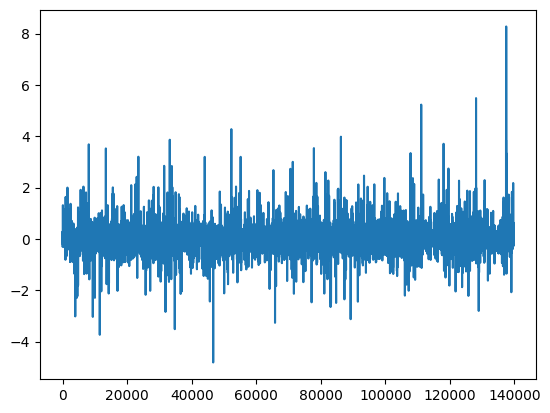

In [90]:
plt.plot(w)
print(np.sum(np.abs(w) <= 1e-3))

### Lasso

Repetiu-se o processo com regularização **L1** (Lasso), que promove **esparsidade** (muitos coeficientes a zero).

**Objetivo**: Obter um modelo mais interpretável e possivelmente com melhor generalização.

Compararam-se os resultados com o modelo L2 e analisaram-se novamente os coeficientes não-nulos.

In [91]:
from sklearn.linear_model import LogisticRegression

dl = LogisticRegression(penalty = 'l1', solver='saga', max_iter = 1000, C = 0.10, tol = 1e-3)
dl.fit(x1, y1)
print(dl.score(x1, y1))
print(dl.score(x2, y2))

0.3406571428571429
0.338


In [92]:
w = dl.coef_[0]
idx = np.argsort(w)
print(np.sum(w!=0))
voc = tfidf.get_feature_names_out()
voc2 = [voc[i] for i in idx]
print(voc2[:50])
print('\n','-'*100,'\n')
print(voc2[-50:])

43
['great', 'veri', 'also', 'well', 'best', 'perform', 'love', 'play', 'stori', 'beauti', 'good', 'enjoy', 'with', 'excel', 'quit', 'more', 'which', 'zucker', 'zombi zombi', 'zombiez', 'zombifi', 'zone', 'zone episod', 'zone that', 'zone with', 'zonk', 'zoom', 'zoom zoom', 'zoot', 'zorba', 'zorba greek', 'zorro', 'abduct', 'zombi without', 'aaliyah', 'aamir', 'aamir khan', 'aankhen', 'aardman', 'aaron', 'aaron altman', 'aaron carter', 'aaron eckhart', 'aaron sorkin', 'aback', 'abandon', 'abandon build', 'abandon hotel', 'zuckerman', 'abil find']

 ---------------------------------------------------------------------------------------------------- 

['zombi this', 'zombi vampir', 'zombi well', 'zombi were', 'zombi what', 'zombi when', 'zombi which', 'zucco', 'abandon mine', 'abandon school', 'abandon their', 'abandon they', 'abandon this', 'abba', 'abbey', 'abbi', 'abbot', 'abbot costello', 'abbott', 'abbott costello', 'abbrevi', 'abdomen', 'abandon hous', 'zudina', 'just', 'garbag', '

#### Validacao Cruzada (L1)

In [93]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(dl, x1, y1, cv=kfold)

print("\nExatidão por fold: ", scores)
print("Média: ", np.round(scores.mean(),4))
print("Desvio Padrão: ", np.round(scores.std(), 4))

# todos os dados
dl_final = LogisticRegression(penalty = 'l1', solver='saga', max_iter = 1000, C = 0.10, tol = 1e-3)
dl_final.fit(x1, y1)


Exatidão por fold:  [0.33057143 0.32942857 0.331      0.32514286 0.32085714]
Média:  0.3274
Desvio Padrão:  0.0039


,penalty,'l1'
,dual,False
,tol,0.001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,1000
,multi_class,'deprecated'


#### classification_report (L1)

In [94]:
y_pred = dl_final.predict(x2)

# Negativa (1-4), Positiva (7-10)
print(classification_report(y2, y_pred,digits=4))

cm = confusion_matrix(y2, y_pred)
print(cm)

exatidao = dl_final.score(x2, y2)
print("Exatidão Total:", round(exatidao, 4))

# Análise de Overfitting
acc_treino = dl_final.score(x1, y1)
acc_teste = exatidao
diferenca = acc_treino - acc_teste
print("Diferença:", round(diferenca, 4))

              precision    recall  f1-score   support

           1     0.3780    0.8229    0.5180      3037
           2     0.0000    0.0000    0.0000      1376
           3     0.5000    0.0007    0.0013      1488
           4     0.2547    0.0256    0.0466      1599
           7     0.2308    0.0146    0.0274      1441
           8     0.2023    0.0501    0.0803      1758
           9     0.0000    0.0000    0.0000      1382
          10     0.3145    0.8294    0.4560      2919

    accuracy                         0.3381     15000
   macro avg     0.2350    0.2179    0.1412     15000
weighted avg     0.2604    0.3381    0.2108     15000

[[2499    0    1    9    7   31    0  490]
 [1002    0    0   16    5   30    1  322]
 [ 952    0    1   30    7   54    0  444]
 [ 845    0    0   41   15   91    0  607]
 [ 348    0    0   34   21   75    0  963]
 [ 311    0    0   18   20   88    0 1321]
 [ 211    0    0    6    4   30    0 1131]
 [ 443    0    0    7   12   36    0 2421]]
Exat

C:\Users\migue\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\migue\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\migue\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

---
# Regressão
Nesta fase, foi prevista a nota exata (1 a 10) usando regressão, e posteriormente foi comparada com a classificação.

In [95]:
modelo_reg = LinearRegression()
modelo_reg.fit(x1, y1)

print("Score R2 (Treino):", modelo_reg.score(x1, y1))
print("Score R2 (Teste):", modelo_reg.score(x2, y2))

Score R2 (Treino): 0.9999858337265202
Score R2 (Teste): 0.5476295984996289


In [96]:
previsoes = modelo_reg.predict(x2)

# Arredondamento
previsoes_arred = np.clip(np.round(previsoes), 1, 10)

# Calcular a exatidão da regressão
acertos = previsoes_arred == y2
exatidao_regressao = acertos.mean()

print("Exatidão da Classificação: ", round(acc_teste, 4))
print("Exatidão da Regressão: ", round(exatidao_regressao, 4))

Exatidão da Classificação:  0.3381
Exatidão da Regressão:  0.2462


In [97]:
# Fazer previsoes
previsoes = modelo_reg.predict(x2)

# Erro médio quadrático
mse = mean_squared_error(y2, previsoes)

# Comparar com classificacao (arredondar as previsoes)
# Isto serve para vermos se a nota prevista arredondada bate certo com a original
previsoes_int = np.round(previsoes)
exatidao_regressao = np.mean(previsoes_arred == y2)

# Ver o erro medio
print("MSE (Regressão):", mse)
print("Exatidão (Regressão arredondada):", exatidao_regressao)

MSE (Regressão): 5.474334912129307
Exatidão (Regressão arredondada): 0.2462


Analisando os resultados da regressão, obteu-se o Erro Quadrático Médio (MSE) de 5.47. Isto significa que, em média, as previsões falham por cerca de 2.3 valores da nota real. Assim, o modelo apresenta algumas dificuldades em captar as nuances das críticas e prever as notas com precisão.

---
# Clustering
Vamos agrupar as criticas sem saber a nota, usando K-Means.

K = 2 feito...
K = 3 feito...
K = 5 feito...
K = 8 feito...
K = 10 feito...


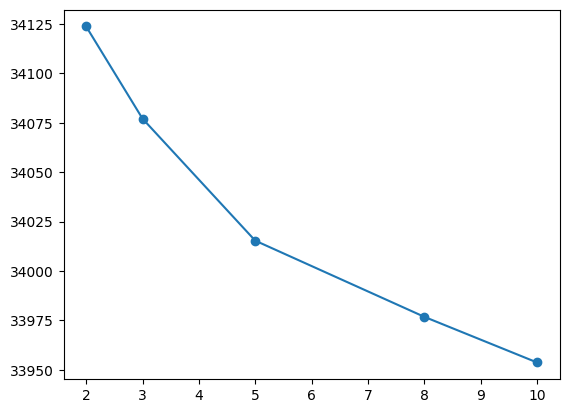

In [98]:
# Tentar achar o melhor k (metodo do cotovelo)
inercias = []
lista_k = [2, 3, 5, 8, 10]
for k in lista_k:
    modelo_km = KMeans(n_clusters=k, random_state=42)
    modelo_km.fit(x1)
    inercias.append(modelo_km.inertia_)
    print("K = " + str(k) + " feito...")

# Plot simples para ver o cotovelo
plt.plot(lista_k, inercias, 'o-')
plt.show()

O número de clusters foi analisado através do método do cotovelo. Observou-se uma redução substantiva da inércia entre k=2 e k=5. A partir desse valor, a diminuição da inércia torna-se progressivamente menor, indicando ganhos cada vez mais pequenos com o aumento do número de clusters. Deste modo, escolheu-se k=5.

In [99]:
# Escolher um k fixo, por exemplo K=5
k_final = 5
modelo_km = KMeans(n_clusters=k_final, random_state=42)
modelo_km.fit(x1)

# Ver as palavras mais frequentes de cada grupo
print("Top palavras por cluster:")
centroides_ordenados = modelo_km.cluster_centers_.argsort()[:, ::-1]
palavras = tfidf.get_feature_names_out()

for i in range(k_final):
    print(f"Cluster {i}:")
    for ind in centroides_ordenados[i, :10]:
        print(' ', palavras[ind], end='')
    print('\n')

Top palavras por cluster:
Cluster 0:
  that  this  with  they  film  movi  have  there  like  what

Cluster 1:
  movi  this  this movi  that  have  watch  like  with  good  just

Cluster 2:
  this  with  that  movi  film  from  have  stori  like  good

Cluster 3:
  film  this  this film  that  with  have  like  veri  from  watch

Cluster 4:
  show  episod  this show  that  this  seri  season  they  watch  have



Ao analisar as palavras mais frequentes de cada grupo (para K=5), identificou-se que o cluster 4 era distinto dos outros pelo facto de mencionar séries de TV, identificado por palavras como "episode", "season" e "series".  Os restantes clusters eram mais semelhantes entre si com palavras como "movie" e "film".

---
# Conclusão

Neste trabalho, explorámos o uso de várias técnicas para analisar as críticas de filmes no IMDB.

Usámos uma "Logistic Regression" para prever a pontuação das críticas de um filme. Com a regularização **L2 (Ridge)**, foi atingida uma exatidão de **43.7%**. Comparando os resultados, notou-se que a Regressão Logística com regularização L1 (Lasso), teve uma exatidão inferior de **33.8%**, mas permitiu eliminar as features menos relevantes. Estes resultados parecem baixos mas são aceitáveis pelo facto de termos 8 categorias possíveis.

Ao tentar prever a nota exata (1-10) do filme, usando a Regressão Linear, foi atingia uma exatidão de 24.6% e o erro quadrático médio (mse) foi de 5.47, o que quer dizer que, em média, as previsões falham por cerca de 2.3 valores. Isto demonstra a dificuldade de prever a nota exata do filme, apenas pelo texto das críticas, sendo mais difícil com a regressão do que com a classificação.

No "clustering" aplicámos o KMeans para agrupar as críticas dos filmes sem usar as notas. Escolhemos k=5 clusters para as agrupar e foi possível verificar que o Cluster 4 era bastante distinto dos outros clusters, pelo facto de mencionar séries de TV, identificado por palavras como "episode", "season" e "series".  Os restantes clusters eram mais semelhantes entre si com palavras como "movie" e "film".

Em conclusão, foi possível classificar as críticas dos filmes em positivas e negativas e detetar alguns padrões óbvios como séries de TV e filmes.